100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [00:59<00:00, 1670.18it/s]


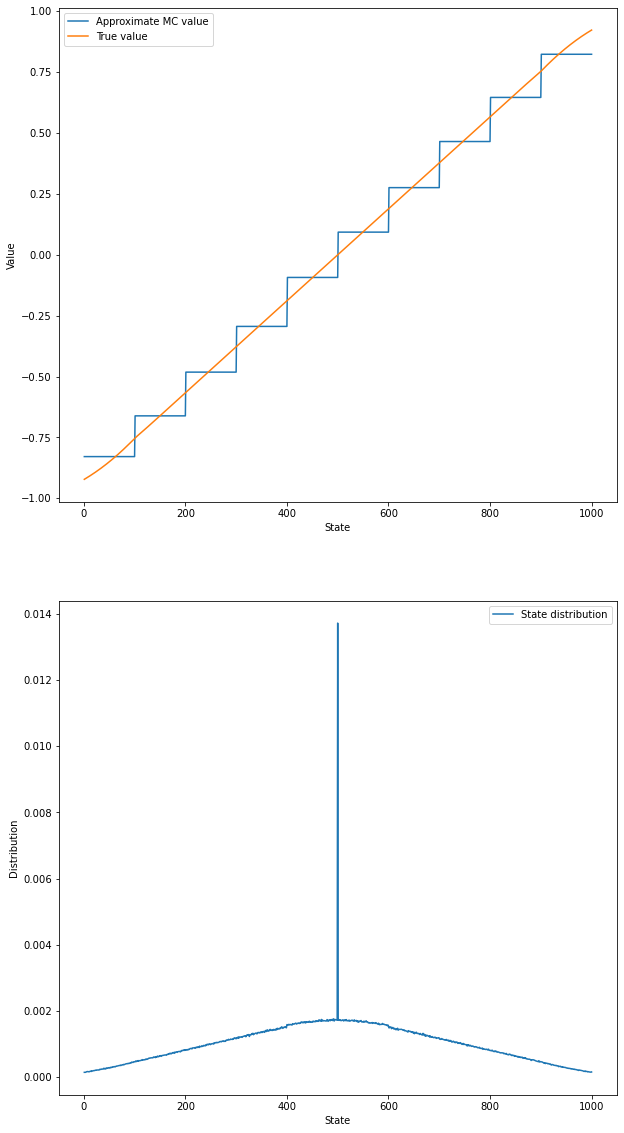

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [04:01<00:00,  2.42s/it]


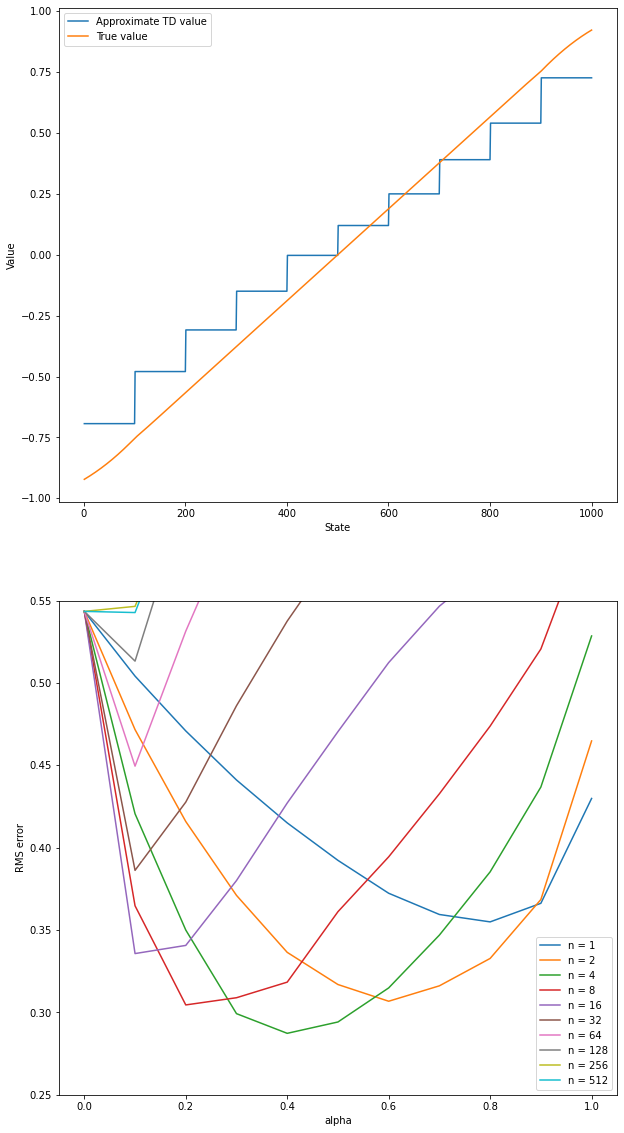

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [03:47<00:00, 21.94it/s]


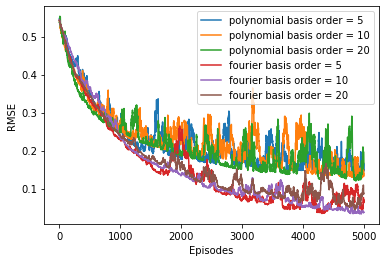

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:08<00:00, 623.15it/s]


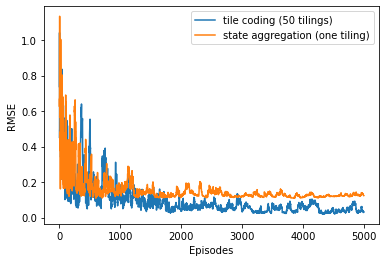

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm

# # of states except for terminal states
N_STATES = 1000

# all states
STATES = np.arange(1, N_STATES + 1)

# start from a central state
START_STATE = 500

# terminal states
END_STATES = [0, N_STATES + 1]

# possible actions
ACTION_LEFT = -1
ACTION_RIGHT = 1
ACTIONS = [ACTION_LEFT, ACTION_RIGHT]

# maximum stride for an action
STEP_RANGE = 100

def compute_true_value():
    # true state value, just a promising guess
    true_value = np.arange(-1001, 1003, 2) / 1001.0

    # Dynamic programming to find the true state values, based on the promising guess above
    # Assume all rewards are 0, given that we have already given value -1 and 1 to terminal states
    while True:
        old_value = np.copy(true_value)
        for state in STATES:
            true_value[state] = 0
            for action in ACTIONS:
                for step in range(1, STEP_RANGE + 1):
                    step *= action
                    next_state = state + step
                    next_state = max(min(next_state, N_STATES + 1), 0)
                    # asynchronous update for faster convergence
                    true_value[state] += 1.0 / (2 * STEP_RANGE) * true_value[next_state]
        error = np.sum(np.abs(old_value - true_value))
        if error < 1e-2:
            break
    # correct the state value for terminal states to 0
    true_value[0] = true_value[-1] = 0

    return true_value

# take an @action at @state, return new state and reward for this transition
def step(state, action):
    step = np.random.randint(1, STEP_RANGE + 1)
    step *= action
    state += step
    state = max(min(state, N_STATES + 1), 0)
    if state == 0:
        reward = -1
    elif state == N_STATES + 1:
        reward = 1
    else:
        reward = 0
    return state, reward

# get an action, following random policy
def get_action():
    if np.random.binomial(1, 0.5) == 1:
        return 1
    return -1

# a wrapper class for aggregation value function
class ValueFunction:
    # @num_of_groups: # of aggregations
    def __init__(self, num_of_groups):
        self.num_of_groups = num_of_groups
        self.group_size = N_STATES // num_of_groups

        # thetas
        self.params = np.zeros(num_of_groups)

    # get the value of @state
    def value(self, state):
        if state in END_STATES:
            return 0
        group_index = (state - 1) // self.group_size
        return self.params[group_index]

    # update parameters
    # @delta: step size * (target - old estimation)
    # @state: state of current sample
    def update(self, delta, state):
        group_index = (state - 1) // self.group_size
        self.params[group_index] += delta

# a wrapper class for tile coding value function
class TilingsValueFunction:
    # @num_of_tilings: # of tilings
    # @tileWidth: each tiling has several tiles, this parameter specifies the width of each tile
    # @tilingOffset: specifies how tilings are put together
    def __init__(self, numOfTilings, tileWidth, tilingOffset):
        self.numOfTilings = numOfTilings
        self.tileWidth = tileWidth
        self.tilingOffset = tilingOffset

        # To make sure that each sate is covered by same number of tiles,
        # we need one more tile for each tiling
        self.tilingSize = N_STATES // tileWidth + 1

        # weight for each tile
        self.params = np.zeros((self.numOfTilings, self.tilingSize))

        # For performance, only track the starting position for each tiling
        # As we have one more tile for each tiling, the starting position will be negative
        self.tilings = np.arange(-tileWidth + 1, 0, tilingOffset)

    # get the value of @state
    def value(self, state):
        stateValue = 0.0
        # go through all the tilings
        for tilingIndex in range(0, len(self.tilings)):
            # find the active tile in current tiling
            tileIndex = (state - self.tilings[tilingIndex]) // self.tileWidth
            stateValue += self.params[tilingIndex, tileIndex]
        return stateValue

    # update parameters
    # @delta: step size * (target - old estimation)
    # @state: state of current sample
    def update(self, delta, state):

        # each state is covered by same number of tilings
        # so the delta should be divided equally into each tiling (tile)
        delta /= self.numOfTilings

        # go through all the tilings
        for tilingIndex in range(0, len(self.tilings)):
            # find the active tile in current tiling
            tileIndex = (state - self.tilings[tilingIndex]) // self.tileWidth
            self.params[tilingIndex, tileIndex] += delta

# a wrapper class for polynomial / Fourier -based value function
POLYNOMIAL_BASES = 0
FOURIER_BASES = 1
class BasesValueFunction:
    # @order: # of bases, each function also has one more constant parameter (called bias in machine learning)
    # @type: polynomial bases or Fourier bases
    def __init__(self, order, type):
        self.order = order
        self.weights = np.zeros(order + 1)

        # set up bases function
        self.bases = []
        if type == POLYNOMIAL_BASES:
            for i in range(0, order + 1):
                self.bases.append(lambda s, i=i: pow(s, i))
        elif type == FOURIER_BASES:
            for i in range(0, order + 1):
                self.bases.append(lambda s, i=i: np.cos(i * np.pi * s))

    # get the value of @state
    def value(self, state):
        # map the state space into [0, 1]
        state /= float(N_STATES)
        # get the feature vector
        feature = np.asarray([func(state) for func in self.bases])
        return np.dot(self.weights, feature)

    def update(self, delta, state):
        # map the state space into [0, 1]
        state /= float(N_STATES)
        # get derivative value
        derivative_value = np.asarray([func(state) for func in self.bases])
        self.weights += delta * derivative_value

# gradient Monte Carlo algorithm
# @value_function: an instance of class ValueFunction
# @alpha: step size
# @distribution: array to store the distribution statistics
def gradient_monte_carlo(value_function, alpha, distribution=None):
    state = START_STATE
    trajectory = [state]

    # We assume gamma = 1, so return is just the same as the latest reward
    reward = 0.0
    while state not in END_STATES:
        action = get_action()
        next_state, reward = step(state, action)
        trajectory.append(next_state)
        state = next_state

    # Gradient update for each state in this trajectory
    for state in trajectory[:-1]:
        delta = alpha * (reward - value_function.value(state))
        value_function.update(delta, state)
        if distribution is not None:
            distribution[state] += 1

# semi-gradient n-step TD algorithm
# @valueFunction: an instance of class ValueFunction
# @n: # of steps
# @alpha: step size
def semi_gradient_temporal_difference(value_function, n, alpha):
    # initial starting state
    state = START_STATE

    # arrays to store states and rewards for an episode
    # space isn't a major consideration, so I didn't use the mod trick
    states = [state]
    rewards = [0]

    # track the time
    time = 0

    # the length of this episode
    T = float('inf')
    while True:
        # go to next time step
        time += 1

        if time < T:
            # choose an action randomly
            action = get_action()
            next_state, reward = step(state, action)

            # store new state and new reward
            states.append(next_state)
            rewards.append(reward)

            if next_state in END_STATES:
                T = time

        # get the time of the state to update
        update_time = time - n
        if update_time >= 0:
            returns = 0.0
            # calculate corresponding rewards
            for t in range(update_time + 1, min(T, update_time + n) + 1):
                returns += rewards[t]
            # add state value to the return
            if update_time + n <= T:
                returns += value_function.value(states[update_time + n])
            state_to_update = states[update_time]
            # update the value function
            if not state_to_update in END_STATES:
                delta = alpha * (returns - value_function.value(state_to_update))
                value_function.update(delta, state_to_update)
        if update_time == T - 1:
            break
        state = next_state

# Figure 9.1, gradient Monte Carlo algorithm
def figure_9_1(true_value):
    episodes = int(1e5)
    alpha = 2e-5

    # we have 10 aggregations in this example, each has 100 states
    value_function = ValueFunction(10)
    distribution = np.zeros(N_STATES + 2)
    for ep in tqdm(range(episodes)):
        gradient_monte_carlo(value_function, alpha, distribution)

    distribution /= np.sum(distribution)
    state_values = [value_function.value(i) for i in STATES]

    plt.figure(figsize=(10, 20))

    plt.subplot(2, 1, 1)
    plt.plot(STATES, state_values, label='Approximate MC value')
    plt.plot(STATES, true_value[1: -1], label='True value')
    plt.xlabel('State')
    plt.ylabel('Value')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(STATES, distribution[1: -1], label='State distribution')
    plt.xlabel('State')
    plt.ylabel('Distribution')
    plt.legend()

    plt.show()
    plt.close()

# semi-gradient TD on 1000-state random walk
def figure_9_2_left(true_value):
    episodes = int(1e5)
    alpha = 2e-4
    value_function = ValueFunction(10)
    for ep in tqdm(range(episodes)):
        semi_gradient_temporal_difference(value_function, 1, alpha)

    stateValues = [value_function.value(i) for i in STATES]
    plt.plot(STATES, stateValues, label='Approximate TD value')
    plt.plot(STATES, true_value[1: -1], label='True value')
    plt.xlabel('State')
    plt.ylabel('Value')
    plt.legend()

# different alphas and steps for semi-gradient TD
def figure_9_2_right(true_value):
    # all possible steps
    steps = np.power(2, np.arange(0, 10))

    # all possible alphas
    alphas = np.arange(0, 1.1, 0.1)

    # each run has 10 episodes
    episodes = 10

    # perform 100 independent runs
    runs = 100

    # track the errors for each (step, alpha) combination
    errors = np.zeros((len(steps), len(alphas)))
    for run in tqdm(range(runs)):
        for step_ind, step in zip(range(len(steps)), steps):
            for alpha_ind, alpha in zip(range(len(alphas)), alphas):
                # we have 20 aggregations in this example
                value_function = ValueFunction(20)
                for ep in range(0, episodes):
                    semi_gradient_temporal_difference(value_function, step, alpha)
                    # calculate the RMS error
                    state_value = np.asarray([value_function.value(i) for i in STATES])
                    errors[step_ind, alpha_ind] += np.sqrt(np.sum(np.power(state_value - true_value[1: -1], 2)) / N_STATES)
    # take average
    errors /= episodes * runs
    # truncate the error
    for i in range(len(steps)):
        plt.plot(alphas, errors[i, :], label='n = ' + str(steps[i]))
    plt.xlabel('alpha')
    plt.ylabel('RMS error')
    plt.ylim([0.25, 0.55])
    plt.legend()

def figure_9_2(true_value):
    plt.figure(figsize=(10, 20))
    plt.subplot(2, 1, 1)
    figure_9_2_left(true_value)
    plt.subplot(2, 1, 2)
    figure_9_2_right(true_value)

    plt.show()
    plt.close()

# Figure 9.5, Fourier basis and polynomials
def figure_9_5(true_value):
    # my machine can only afford 1 run
    runs = 1

    episodes = 5000

    # # of bases
    orders = [5, 10, 20]

    alphas = [1e-4, 5e-5]
    labels = [['polynomial basis'] * 3, ['fourier basis'] * 3]

    # track errors for each episode
    errors = np.zeros((len(alphas), len(orders), episodes))
    for run in range(runs):
        for i in range(len(orders)):
            value_functions = [BasesValueFunction(orders[i], POLYNOMIAL_BASES), BasesValueFunction(orders[i], FOURIER_BASES)]
            for j in range(len(value_functions)):
                for episode in tqdm(range(episodes)):

                    # gradient Monte Carlo algorithm
                    gradient_monte_carlo(value_functions[j], alphas[j])

                    # get state values under current value function
                    state_values = [value_functions[j].value(state) for state in STATES]

                    # get the root-mean-squared error
                    errors[j, i, episode] += np.sqrt(np.mean(np.power(true_value[1: -1] - state_values, 2)))

    # average over independent runs
    errors /= runs

    for i in range(len(alphas)):
        for j in range(len(orders)):
            plt.plot(errors[i, j, :], label='%s order = %d' % (labels[i][j], orders[j]))
    plt.xlabel('Episodes')
    # The book plots RMSVE, which is RMSE weighted by a state distribution
    plt.ylabel('RMSE')
    plt.legend()

    plt.show()
    plt.close()

# Figure 9.10, it will take quite a while
def figure_9_10(true_value):

    # My machine can only afford one run, thus the curve isn't so smooth
    runs = 1

    # number of episodes
    episodes = 5000

    num_of_tilings = 50

    # each tile will cover 200 states
    tile_width = 200

    # how to put so many tilings
    tiling_offset = 4

    labels = ['tile coding (50 tilings)', 'state aggregation (one tiling)']

    # track errors for each episode
    errors = np.zeros((len(labels), episodes))
    for run in range(runs):
        # initialize value functions for multiple tilings and single tiling
        value_functions = [TilingsValueFunction(num_of_tilings, tile_width, tiling_offset),
                         ValueFunction(N_STATES // tile_width)]
        for i in range(len(value_functions)):
            for episode in tqdm(range(episodes)):
                # I use a changing alpha according to the episode instead of a small fixed alpha
                # With a small fixed alpha, I don't think 5000 episodes is enough for so many
                # parameters in multiple tilings.
                # The asymptotic performance for single tiling stays unchanged under a changing alpha,
                # however the asymptotic performance for multiple tilings improves significantly
                alpha = 1.0 / (episode + 1)

                # gradient Monte Carlo algorithm
                gradient_monte_carlo(value_functions[i], alpha)

                # get state values under current value function
                state_values = [value_functions[i].value(state) for state in STATES]

                # get the root-mean-squared error
                errors[i][episode] += np.sqrt(np.mean(np.power(true_value[1: -1] - state_values, 2)))

    # average over independent runs
    errors /= runs

    for i in range(0, len(labels)):
        plt.plot(errors[i], label=labels[i])
    plt.xlabel('Episodes')
    # The book plots RMSVE, which is RMSE weighted by a state distribution
    plt.ylabel('RMSE')
    plt.legend()

    plt.show()
    plt.close()

if __name__ == '__main__':
    true_value = compute_true_value()

    figure_9_1(true_value)
    figure_9_2(true_value)
    figure_9_5(true_value)
    figure_9_10(true_value)

10 samples
40 samples
160 samples
640 samples
2560 samples
10240 samples


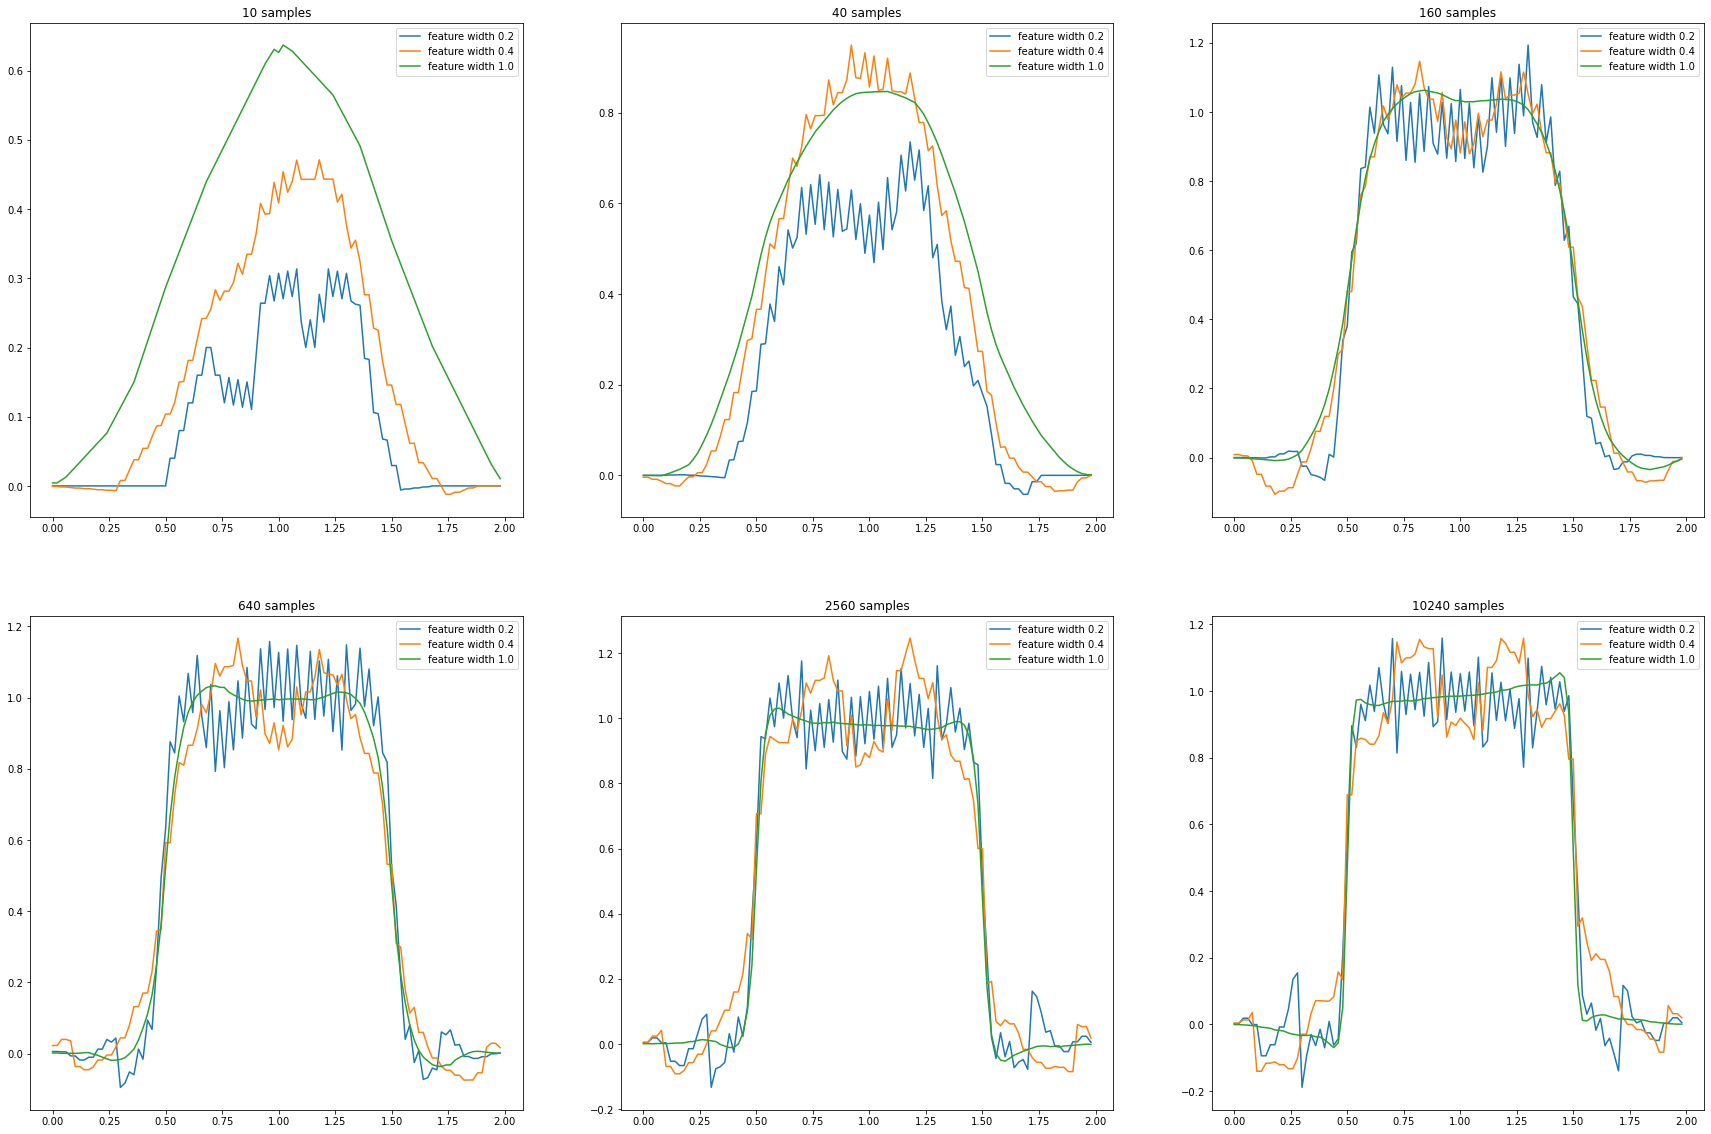

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm

# wrapper class for an interval
# readability is more important than efficiency, so I won't use many tricks
class Interval:
    # [@left, @right)
    def __init__(self, left, right):
        self.left = left
        self.right = right

    # whether a point is in this interval
    def contain(self, x):
        return self.left <= x < self.right

    # length of this interval
    def size(self):
        return self.right - self.left

# domain of the square wave, [0, 2)
DOMAIN = Interval(0.0, 2.0)

# square wave function
def square_wave(x):
    if 0.5 < x < 1.5:
        return 1
    return 0

# get @n samples randomly from the square wave
def sample(n):
    samples = []
    for i in range(0, n):
        x = np.random.uniform(DOMAIN.left, DOMAIN.right)
        y = square_wave(x)
        samples.append([x, y])
    return samples

# wrapper class for value function
class ValueFunction:
    # @domain: domain of this function, an instance of Interval
    # @alpha: basic step size for one update
    def __init__(self, feature_width, domain=DOMAIN, alpha=0.2, num_of_features=50):
        self.feature_width = feature_width
        self.num_of_featrues = num_of_features
        self.features = []
        self.alpha = alpha
        self.domain = domain

        # there are many ways to place those feature windows,
        # following is just one possible way
        step = (domain.size() - feature_width) / (num_of_features - 1)
        left = domain.left
        for i in range(0, num_of_features - 1):
            self.features.append(Interval(left, left + feature_width))
            left += step
        self.features.append(Interval(left, domain.right))

        # initialize weight for each feature
        self.weights = np.zeros(num_of_features)

    # for point @x, return the indices of corresponding feature windows
    def get_active_features(self, x):
        active_features = []
        for i in range(0, len(self.features)):
            if self.features[i].contain(x):
                active_features.append(i)
        return active_features

    # estimate the value for point @x
    def value(self, x):
        active_features = self.get_active_features(x)
        return np.sum(self.weights[active_features])

    # update weights given sample of point @x
    # @delta: y - x
    def update(self, delta, x):
        active_features = self.get_active_features(x)
        delta *= self.alpha / len(active_features)
        for index in active_features:
            self.weights[index] += delta

# train @value_function with a set of samples @samples
def approximate(samples, value_function):
    for x, y in samples:
        delta = y - value_function.value(x)
        value_function.update(delta, x)

# Figure 9.8
def figure_9_8():
    num_of_samples = [10, 40, 160, 640, 2560, 10240]
    feature_widths = [0.2, 0.4, 1.0]
    plt.figure(figsize=(30, 20))
    axis_x = np.arange(DOMAIN.left, DOMAIN.right, 0.02)
    for index, num_of_sample in enumerate(num_of_samples):
        print(num_of_sample, 'samples')
        samples = sample(num_of_sample)
        value_functions = [ValueFunction(feature_width) for feature_width in feature_widths]
        plt.subplot(2, 3, index + 1)
        plt.title('%d samples' % (num_of_sample))
        for value_function in value_functions:
            approximate(samples, value_function)
            values = [value_function.value(x) for x in axis_x]
            plt.plot(axis_x, values, label='feature width %.01f' % (value_function.feature_width))
        plt.legend()

    plt.show()
    plt.close()

if __name__ == '__main__':
    figure_9_8()